# Preparation
Import the modules:

In [1]:
import time
import numpy as np
import pandas as pd
import kernels as k
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Let's bring the kernels into the module `kernels.py`:

In [2]:
# %load kernels.py
import numpy as np


# Kernels
def linear(x, y, _):
    return np.dot(x, y)


def polynomial(x, y, p):
    return (1 + np.dot(x, y)) ** p


def gaussian(x, y, beta):
    return np.exp((-beta) * (np.sqrt(np.sum((x - y) ** 2)) ** 2))


kernels = {
    "linear": linear,
    "polynomial": polynomial,
    "gaussian": gaussian
}


Initial parameters:

In [3]:
# for linear
unnecessary = [0]
# for polynomial
degree = [2, 3, 4, 5]
# for gaussian
beta = [1, 2, 3, 4, 5]
# constraints on support vector coefficients
C = [0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]

Function for reading from a file:

In [4]:
def read_csv(path):
    dataset = pd.read_csv(path)
    dataset['class'] = dataset['class'].map({'P': 1, 'N': -1})
    x = np.array(dataset[['x', 'y']].values.tolist())
    y = np.array(dataset['class'].values.tolist())
    return x, y

# Support Vector Machine
Function to convert indexes into array values:

In [5]:
def indexes_to_value(arr, indexes):
    return np.array([arr[i] for i in indexes])

Function for dividing the array into test and train in proportion (analogue of k-fold):

In [6]:
def separator(x, y, parts, shuffle=False):
    indexes = np.arange(0, len(x))
    if shuffle:
        np.random.shuffle(indexes)
    block_size = np.math.ceil(len(x) / parts)
    x_test, y_test, x_train, y_train = [], [], [], []
    for i in range(parts):
        l = block_size * i
        r = block_size * (i + 1)
        indexes_test = indexes[l:r]
        indexes_train = np.concatenate((indexes[:l], indexes[r:]))
        x_test.append(indexes_to_value(x, indexes_test))
        y_test.append(indexes_to_value(y, indexes_test))
        x_train.append(indexes_to_value(x, indexes_train))
        y_train.append(indexes_to_value(y, indexes_train))
    return np.array(x_test), np.array(y_test), np.array(x_train), np.array(y_train)

Function that implements the support vector machine:

In [7]:
def svm(c, x, y, kernel):
    omega, eps, size = 0, 1e-8, len(y)
    omegas = np.zeros(size)
    kernels = np.array([[kernel(x[i], x[q]) for q in range(size)] for i in range(size)])
    for _ in range(150):
        for i in range(size):
            error_i = omega + np.sum(y * omegas * kernels[i]) - y[i]
            # take one more element for optimization
            q = np.random.randint(0, size)
            while i == q: q = np.random.randint(0, size)
            error_q = omega + np.sum(y * omegas * kernels[q]) - y[q]
            if y[i] * error_i > eps and omegas[i] > 0 or y[i] * error_i < -eps and omegas[i] < c:
                save_omega_i = omegas[i]
                save_omega_q = omegas[q]

                # boundaries
                l = max(0, omegas[q] - omegas[i]) if y[i] != y[q] else max(0, omegas[i] + omegas[q] - c)
                r = min(c, c + omegas[q] - omegas[i]) if y[i] != y[q] else min(c, omegas[i] + omegas[q])

                # calculate the derivative
                derivative = 2 * kernels[i][q] - kernels[i][i] - kernels[q][q]

                # confirm that it is less than zero
                if abs(l - r) < 1e-10 or derivative >= 0:
                    continue

                omegas[q] = min(max(omegas[q] - y[q] * (error_i - error_q) / derivative, l), r)
                if abs(omegas[q] - save_omega_q) < eps:
                    continue
                omegas[i] += y[i] * y[q] * (save_omega_q - omegas[q])

                phi_i = y[i] * (omegas[i] - save_omega_i)
                phi_q = y[q] * (omegas[q] - save_omega_q)

                omega_l = omega - error_i - phi_i * kernels[i][i] - phi_q * kernels[i][q]
                omega_r = omega - error_q - phi_i * kernels[i][q] - phi_q * kernels[q][q]

                omega = omega_l if 0 < omegas[i] < c else (omega_r if 0 < omegas[q] < c else (omega_l + omega_r) / 2)
    return omega, omegas

Function to find the class:

In [8]:
# linear classifier
def predict(kernel, omega, omegas, x, x_train, y_train):
    return np.sign(np.sum(omegas * y_train * np.array([kernel(x, y) for y in x_train])) + omega)

Functions for evaluating the algorithm:

In [9]:
def class_to_int(target_class):
    return 0 if target_class == 1 else 1


def calc_f_measure(confusion_matrix):
    size = len(confusion_matrix)
    precision = sum([confusion_matrix[i][i] / max(sum(confusion_matrix[i]), 0.01) for i in range(size)]) / size
    recall = sum([confusion_matrix[i][i] / max(sum(confusion_matrix[:, i]), 0.01) for i in range(size)]) / size
    return 2 * precision * recall / (precision + recall)


def calc_accuracy(confusion_matrix):
    size = len(confusion_matrix)
    tp = confusion_matrix[0][0]
    tn = confusion_matrix[1][1]
    total = sum([sum(confusion_matrix[i]) for i in range(size)])
    return (tp + tn) / total

# Analysis
Find the best combination of hyperparameters:

In [10]:
def cross_validation(parts, calc_assessment, x, y, kernel, params):
    x_test, y_test, x_train, y_train = separator(x, y, parts, True)
    best_params = [0, 0, 0]  # classifier assessment, C, params
    for c in C:
        for p in params:
            kernel_p = lambda x1, y1: kernel(x1, y1, p)
            number_classes = len({'P': 1, 'N': -1})
            confusion_matrix = np.zeros((number_classes, number_classes))
            for part in range(parts):
                omega, omegas = svm(c, x_train[part], y_train[part], kernel_p)
                for x1, y1 in zip(x_test[part], y_test[part]):
                    y_predicted = class_to_int(predict(kernel_p, omega, omegas, x1, x_train[part], y_train[part]))
                    y_actual = class_to_int(y1)
                    confusion_matrix[y_actual][y_predicted] += 1
            assessment = calc_assessment(confusion_matrix)
            if best_params[0] < assessment:
                best_params = assessment, c, p
    return best_params

def find_best(parts, calc_assessment, x, y):
    for (kernel_name, kernel) in k.kernels.items():
        if kernel_name == "linear":
            name = "unnecessary"
            params = unnecessary
        elif kernel_name == "polynomial":
            name = "degree"
            params = degree
        else:
            name = "beta"
            params = beta
        res = cross_validation(parts, calc_assessment, x, y, kernel, params)
        print(kernel_name + ":" +
              " assessment = " + str(res[0]) +
              ", best C = " + str(res[1]) +
              ", best " + name + " = " + str(res[2]))

For the best combination of hyperparameters found, construct how the implemented algorithm works in the source space:

In [11]:
def graph(x, y, kernel, params):
    def get_color(cur_y):
        return 'green' if cur_y >= 0 else 'red'

    c, p = params
    kernel_p = lambda x1, y1: kernel(x1, y1, p)
    omega, omegas = svm(c, x, y, kernel_p)

    for i in range(len(x)):
        plt.scatter(x[i, 0], x[i, 1], marker=('+' if y[i] == 1 else '_'), c=get_color(y[i]), s=100)

    qty = 100
    xy = plt.gca()
    m_xy = xy.get_xlim(), xy.get_ylim()
    bg_X = np.array([[m_xy[0][0] + i * ((m_xy[0][1] - m_xy[0][0]) / qty),
                      m_xy[1][0] + j * ((m_xy[1][1] - m_xy[1][0]) / qty)]
                     for j in range(qty) for i in range(qty)])
    bg_Y = [predict(kernel_p, omega, omegas, np.array([x1, x2]), x, y) for x1, x2 in bg_X]
    plt.scatter(bg_X[:, 0], bg_X[:, 1], marker='.', c=[get_color(cur_y) for cur_y in bg_Y], alpha=0.3)
    plt.show()

In [12]:
start_time = time.time()

# microchip scrap detection
chips_x, chips_y = read_csv('./datasets/chips.csv')
# data on the eruption of the yellowstone volcano
geyser_x, geyser_y = read_csv('./datasets/geyser.csv')

In [13]:
print("Chips")
find_best(8, calc_accuracy, chips_x, chips_y)

Chips
linear: assessment = 0.4576271186440678, best C = 10.0, best unnecessary = 0
polynomial: assessment = 0.8220338983050848, best C = 1.0, best degree = 5
gaussian: assessment = 0.8305084745762712, best C = 5.0, best beta = 2


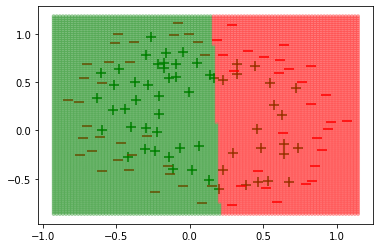

In [14]:
graph(chips_x, chips_y, k.linear, [10.0, 0])

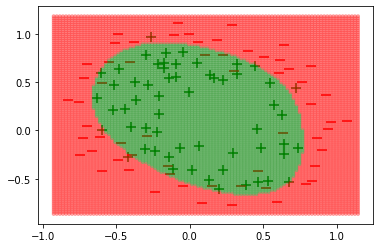

In [32]:
graph(chips_x, chips_y, k.polynomial, [1.0, 5])

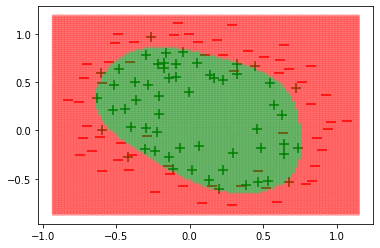

In [31]:
graph(chips_x, chips_y, k.gaussian, [5.0, 2])

In [17]:
print("Geyser")
find_best(8, calc_accuracy, geyser_x, geyser_y)

Geyser
linear: assessment = 0.9009009009009009, best C = 5.0, best unnecessary = 0
polynomial: assessment = 0.8918918918918919, best C = 0.1, best degree = 2
gaussian: assessment = 0.8918918918918919, best C = 0.5, best beta = 1


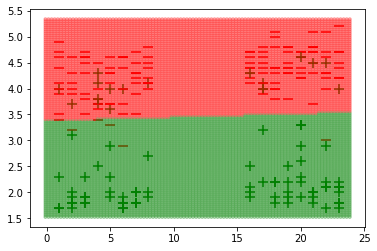

In [28]:
graph(geyser_x, geyser_y, k.linear, [5.0, 0])

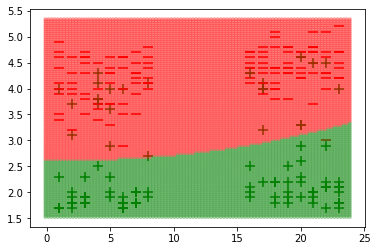

In [19]:
graph(geyser_x, geyser_y, k.polynomial, [0.1, 2])

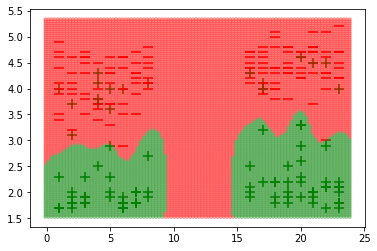

In [30]:
graph(geyser_x, geyser_y, k.gaussian, [0.5, 1])

In [21]:
print("Total working time: %s seconds." % (time.time() - start_time))

Total working time: 1216.186184644699 seconds.
